<a href="https://colab.research.google.com/github/kasparvonbeelen/lancaster-newspaper-workshop/blob/wc/word_counts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data/Culture Workshop, Lancaster
## Content Analysis of Historical Newspapers


In [8]:
# let's just turn of
import warnings
warnings.filterwarnings('ignore')

# OCR quality

In this notebook, we have a closer look at exploring newspaper content. But before we do that, let's have a look at the quality of the text data.

A major hurdle for analysing the historical press, is the sometimes awful quality of the automatic text transcription, using Optical Character Recognition (OCR) software, which converts images to machine-readable text.

And here ```m4n y th**in^gs can go wrong!```

So before analysing/reading our sources, we should determine what is readable and how data quality might impact our findings.

In this notebook, we investigate if the OCR errors are truly randomly distributed or more skewed towards certain categories of newspapers. This could inform how we read our findings later on.

In [4]:
# We need to import the pandas library for working with spreadsheet
import pandas as pd
import re # another library for matching patterns in text
import plotly.express as px
import numpy as np
import seaborn as sns # import seaborn for making plots a bit prettier
import matplotlib.pyplot as plt
sns.set()

In [2]:
# load the dataframe from github
df = pd.read_csv("https://raw.githubusercontent.com/kasparvonbeelen/lancaster-newspaper-workshop/wc/data/subsample500mixedocr-selected_mitch.csv")
# for convenience we drop rows that have nan (not a number values)
# otherwise some of the scripts and operation might crash
df.dropna(inplace=True)

We can print the first n-rows to get a sense of the information available to us.

In [3]:
df.head(3)

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
0,2249,624,art0017,The Bee-Hive.,British Library Heritage Made Digital Newspapers,1871-06-24,1871,6,24,"London, England",271,0.9098,liberal,1d,"THE TICHBORNE CASE. On Tuesday, before the So..."
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2791,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....
2,2250,406,art0024,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1878-04-06,1878,4,6,"London, England",304,0.9870,liberal,2d,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...


### Scatter plots

The most 'direct' way to interrogate data is to look at scatterplots.

In [9]:
fig = px.scatter(df,
                 x="word_count",
                 y="ocrquality",
                 color="political_leaning_label",
                 hover_data=['date','newspaper_title',"political_leaning_label", "price_label"],
                 trendline_scope="overall",
                 trendline="ols",
                 width=1000, height=500,
                 )
fig.update_layout(showlegend=True)
fig.show()

### Log-scale


A common technique to declutter the visualisation is to use a log-scale, this will make a small difference bigger and a big difference smaller.

In [10]:
print(np.log([1, 5]))
print(np.log([100,1000]))

[0.         1.60943791]
[4.60517019 6.90775528]


In [15]:
df = df[(df.ocrquality > 0) & (df.word_count > 0)]
df['word_count_log'] = np.log(df['word_count'] )
fig = px.scatter(df,
                 x="word_count_log",
                 y="ocrquality",
                 color="political_leaning_label",
                 hover_data=['date','newspaper_title',"political_leaning_label", "price_label"],
                 trendline_scope="overall",
                 trendline="ols",
                 width=1000, height=500,
                 )
fig.update_layout(showlegend=True)
fig.show()

### Exercise

Plot the OCR quality over time using a scatter plot.

In [16]:
# enter code here

### Other plotting options

We can visualize distributions as histograms or density plots.

political_leaning_label
conservative    Axes(0.125,0.11;0.775x0.77)
liberal         Axes(0.125,0.11;0.775x0.77)
Name: ocrquality, dtype: object

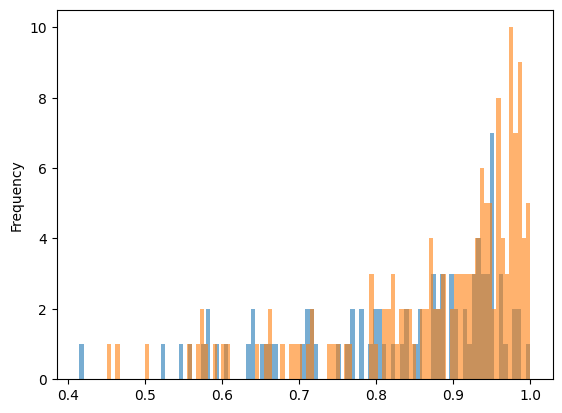

In [18]:
df[df.political_leaning_label.isin(['conservative','liberal'])].groupby(['political_leaning_label'])['ocrquality'].plot(kind='hist', bins=100, alpha=.6)

political_leaning_label
conservative    Axes(0.125,0.11;0.775x0.77)
liberal         Axes(0.125,0.11;0.775x0.77)
Name: ocrquality, dtype: object

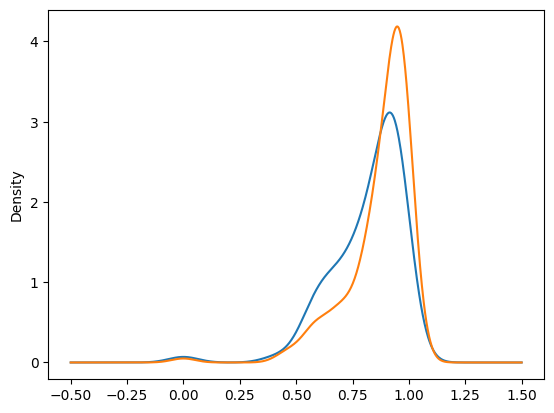

In [ ]:
df[df.political_leaning_label.isin(['conservative','liberal'])].groupby(['political_leaning_label'])['ocrquality'].plot(kind='density')

### Exercise

Is the OCR of the halfpenny press (½ d) worse than the papers priced at 1d? For the exercise, ignore all other newspapers outside of these price points.

In [ ]:
df.price_label.value_counts()

price_label
1d                 270
½ d<SEP>1d          48
½ d                 26
1d<SEP>2d           25
1 ½ d               15
4 ½ d               11
3 ½ d<SEP>4 ½ d     11
3d<SEP>4d            5
3 ½ d<SEP>1d         5
1d<SEP>1d            3
1 ½ d<SEP>2 ½ d      3
2d                   2
2 ½ d<SEP>3 ½ d      1
4d                   1
1id<SEP>1d           1
Name: count, dtype: int64

In [ ]:
# enter your answer here, adapt the previous line of code df[df.political_leaning_label.


# Content Analysis

##  Counting Words with Regular Expressions

Regular expressions offer a convenient tool to explore content by searching and investigating the occurrence of specific patterns in the corpus.

Below we construct a regular expression in which we aim to capture multiple words (and variants) at once.

In abstract terms, the regex follows the format:
`"\b(query_1|query_2|...|query_n)\b"`

- `\b` indicates a word break, which can be a white space or interpunction symbol
- `|` indicates OR, i.e. we want to find any of the queried items
- `s?` ensures we include plural forms

In Python, we first formulate the regex as a 'raw' string (a string prefixed by `r`' and then compile it, where add extra flags, in this `re.I` ignoring the difference between upper and lower case)

In [20]:
# define the regular expression
regex = r"\b(trains?|rails?)\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I)

In [21]:
# test the regex on a particular example
example_text = 'I took to trAin from Euston to Lancaster, but thetrain was delayed because there were leaves on the rails!'
pattern.findall(example_text)

['trAin', 'rails']

Instead of applying the regex to one example, we can apply it to all items in the `text` column of our dataframe. For this, we need to apply the `.apply` method (what's in a name!) to the text column.

What does this operation return? For each row, it will return words that match our query regex, or return an empty list (or `[]`) in case we do not find anything!

In the code cell below, we apply the regex to all items in our dataframe.

In [22]:
df['text'].apply(pattern.findall)

0      []
1      []
2      []
3      []
4      []
       ..
484    []
485    []
495    []
496    []
497    []
Name: text, Length: 424, dtype: object

Of course, we want to store the result of the `pattern.findall` operation and add the query results as a new column to the dataframe. In `pandas` this is relatively straightforward and resembles the variable assignment operation.

After saving the results in a new column, we can keep track of the number of matched items in the text (and the corpus). These results are stored in the `num_hits` column.

In [ ]:
df['hits'] = df['text'].apply(pattern.findall) # safe the query results in a new column
df['num_hits'] = df['hits'].apply(len) # count the number of items found

In [ ]:
df['num_hits'].value_counts() # get the distribution of hits

num_hits
0    399
1     20
2      3
8      2
5      1
3      1
6      1
Name: count, dtype: int64

<Axes: xlabel='num_hits'>

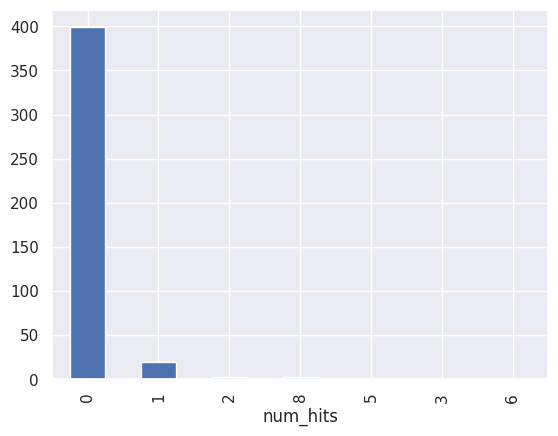

In [ ]:
df['num_hits'].value_counts().plot(kind='bar') # plot the distribution as a bar chart

We can inspect the result of the `findall` operation more closely, and zoom in on the examples where we encounter more than one hit. We use `df.num_hits > 0` as a filter to select only rows with contain at least one mention of 'train' or 'rails'.

In [23]:
df_with_hits = df[df.num_hits > 0].reset_index()
df_with_hits[['hits','text']]

AttributeError: 'DataFrame' object has no attribute 'num_hits'

We print the full content of the 4th text.

In [ ]:
print(df_with_hits.iloc[4][['hits','text']].text)

STEAM TO A.USTRALIA UNDER. SIXTY DAYS  PASSAOz MONET, £l4 AND UPWARDS.  13 ACk BALL LINE of BRITISH and LAUSTRALIAN BX-ROYAL MAIL PACKETS, and EKOLE LINE of Packets, in conjunction with thesciebrated Auxitiary . . Screw Steam Clipper 'vREAT BRITAIN appointed to Sail punctually from Liverctusl on the sth and 13th ot each ntouth, te the consignmest of Bright, Brothers and Co., Melbourne.  The above Line' in addition to being the only r.ne with Steaoms out of Liverpool, is composed of the LAROEST, FINEST, AND FASTEST MERCHANT SHIPS IN THA WORLD.  Shin. Register. Burthen. Captain. Date. Great Britain 1763 500h.p, Gray July 16 Lightning 1769 6000 Clarke Aug. 5 Empress of theScal 757 5000 Bragg to follow Marco Polo 1625 4500 Johnston to follow To be succeeded by the following clippers and steamers— Great Britain Marco Polo Lightning Ocean Chief Champion of the Seas British Trident Donald he Kay Oipsey Bride Great Tasmania Morning Light Eagle Commodore Perry Saidantha Montmorency The above ce

### Exercise

Print the content of the 7th text.

In [ ]:
# enter code here

### Exercise

Search the newspaper dataframe for two (or more!) words of choice.

#### Easy version

Select query terms and see how often these appear in the corpus.

In [ ]:
query_1 = '' # add a query term between the quotation marks
query_2 = '' # add a query term between the quotation marks

regex = rf"\b({query_1}|{query_2})\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I) # compile
df['hits'] = df['text'].apply(pattern.findall) # safe the query results in a new column
df['num_hits'] = df['hits'].apply(len) # count the number of items found
df['num_hits'].value_counts()

num_hits
0    411
1     13
2      1
3      1
5      1
Name: count, dtype: int64

#### Advanced version

- Define a new regular expression that queries the corpus for at least 2 words.
- Look at the previous examples and adapt the code to plot the distribution of the hits.


In [ ]:
regex = ''
pattern = re.compile(regex, re.I) # compile
df['hits'] = df['text'].apply
= df['hits'].apply(len)
# plot the distribution of hits

SyntaxError: invalid syntax (<ipython-input-121-d3cb6ee489cc>, line 4)

# Text and Metadata

Simply counting how often certain items appear is not that interesting. To use newspaper archives for making historical arguments, we often rely on metadata. More precisely, studying the relation between metadata and full-text content is where things get interesting historically.

Below we have a closer (and practical) look at some examples.


The code below repeats the regex-based search operations we discussed previously.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/kasparvonbeelen/lancaster-newspaper-workshop/wc/data/subsample500mixedocr-selected_mitch.csv")
df.dropna(inplace=True)

# define the regular expression
regex = r"\b(trains?|rails?)\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I)
df['hits'] = df['text'].apply(pattern.findall) # safe the query results in a new column
df['num_hits'] = df['hits'].apply(len) # count the number of items found


## Timelines

We group the results by year and count how often we encounter 'trains' in historical newspapers over the nineteenth century.

### Questions

- What is shown in the timeline below?
- And how could it be misleading?

<Axes: xlabel='year'>

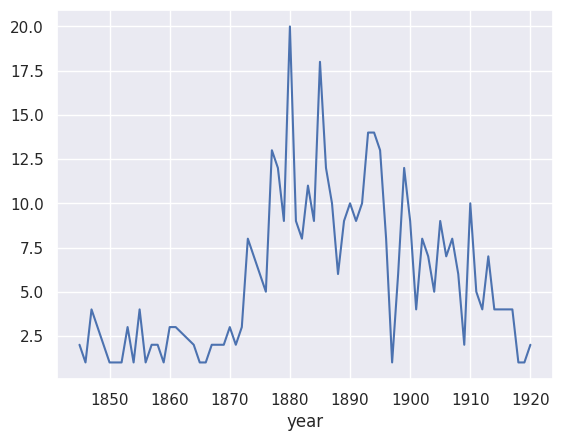

In [ ]:
df.groupby('year')['num_hits'].count().plot()

To investigate change over time, we need to 'normalize' results by year, to make the results comparable. One way of doing this is to divide the number of hits, by the total number of words.

As seen previously, we can use `.split()` to divide the string by white spaces, and then count the number of 'words'*

*or a proxy to the number of words.

In [ ]:
an_example_text = "This sentence has 5 words."
words = an_example_text.split()
print(words)
num_words = len(words)
print(num_words)

['This', 'sentence', 'has', '5', 'words.']
5


In [ ]:
sentence = "This sentence has 5 words."
len(sentence.split())

5

Below we inspect the distribution of the document lengths using a histogram...

<Axes: ylabel='Frequency'>

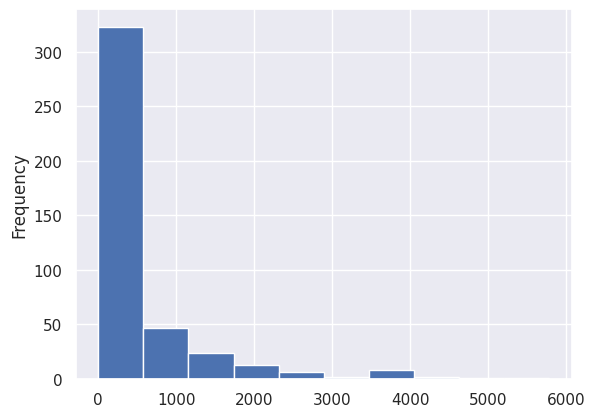

In [ ]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
df['num_words'].plot(kind='hist')

... Or plot the number of words by year.

<Axes: xlabel='year'>

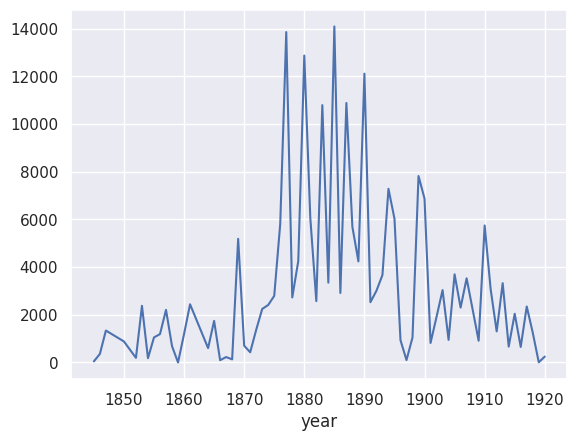

In [ ]:
df.groupby('year')['num_words'].sum().plot()

We can use these total counts to plot a timeline that shows the prevalence of a topic while accounting for the changes in corpus size.

To do this, we sum the number of hits and divide this by the total number of words for each year.

<Axes: xlabel='year'>

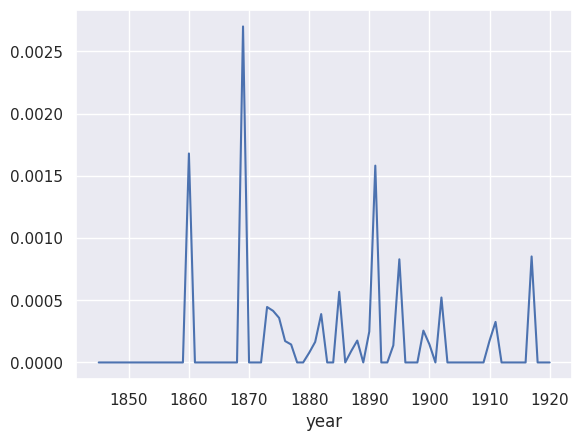

In [ ]:
df_grouped = df.groupby('year').apply(lambda x: x['num_hits'].sum() / x['num_words'].sum())
df_grouped.plot()

What might be confusing about the plot is that they (kind of) point in different directions. Should we believe the 'raw' counts or the normalized frequencies?

The short answer is that both are not reliable. Even though we imagine observing trends, we don't have enough data in this case to make any claims about historical change.

Why do I think this is the case?

We can plot the relative number of hits with confidence intervals (using the `seaborn` library).

<Axes: xlabel='year', ylabel='ratio'>

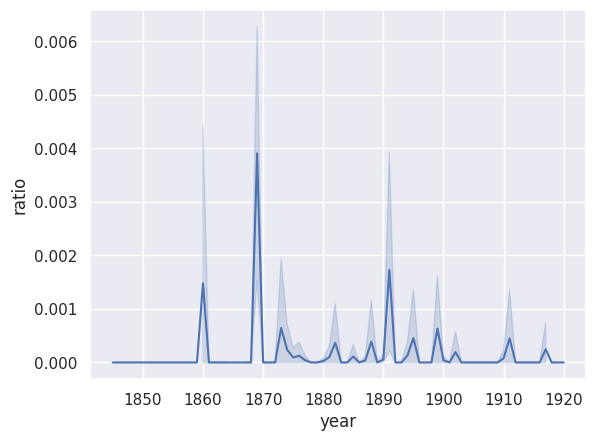

In [ ]:
df['ratio'] = df['num_hits'] /  df['num_words']
sns.lineplot(x='year',y='ratio', data=df)

## Intermezzo: Understanding confidence intervals

In [24]:
from random import shuffle, random
scores = [random() for _ in range(100)]
scores[:3]

[0.6006012224835438, 0.1126128304520787, 0.5171912733708696]

In [25]:
print(np.mean(scores))

0.5007840985934778


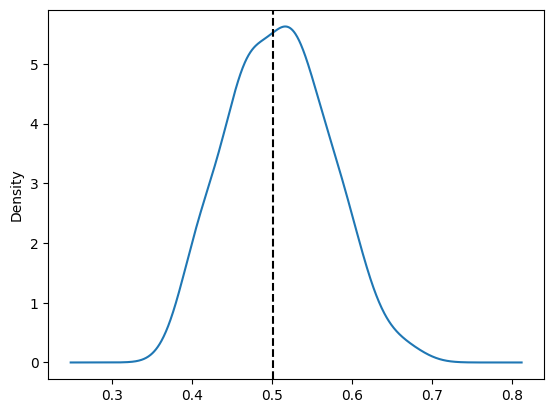

In [26]:
size = 20
n_trials = 100
means = []
for _ in range(n_trials):
  shuffle(scores)
  means.append(sum(scores[:size]) / size)
ax = pd.Series(means).plot(kind='density')
ax.axvline(sum(scores)/len(scores), color="black", linestyle="dashed")

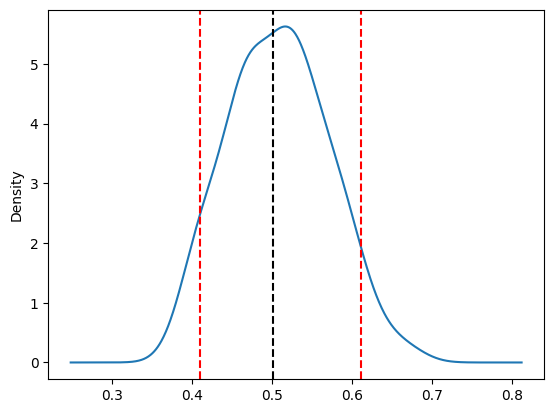

In [27]:
percentiles = np.percentile(means,q=[5.,95.])
ax = pd.Series(means).plot(kind='density')
ax.axvline(sum(scores)/len(scores), color="black", linestyle="dashed")
ax.axvline(percentiles[0], color="red", linestyle="dashed")
ax.axvline(percentiles[1], color="red", linestyle="dashed")

## Politics



In [ ]:
df.political_leaning_label.unique()

array(['liberal', 'independent', 'neutral', 'constitutional',
       'liberal; conservative', 'unionist', 'independent; conservative',
       'conservative'], dtype=object)

## Guided Exercise: Politics and Language

- Create a simplified schema of these political labels that map each of the categories to either 'left', 'right' or 'non-aligned'.
- Save the simplified labels in a new column `political_labels_simplified`.
- Print the number of hits by political party using the simplified schema.
- Visualize the results using a barplot.

In [ ]:
## Enter code here

## create a mapping

## mapping = {'liberal': ...}

## apply mapping df[''].replace

## use value_counts() to see the number of hits by party
sns.barplot(x='political_labels_simplified',y='ratio', data=df)
plt.xticks(rotation=70)

#### Solution

Uncomment the code below.

In [28]:
# mapping = {'liberal': 'left',
#            'independent': 'non-aligned',
#            'neutral': 'non-aligned',
#            'constitutional': 'right',
#             'liberal; conservative': 'non-aligned',
#             'unionist':'right',
#             'independent; conservative': 'right',
#             'conservative':'right'}

In [29]:
# df['political_labels_simplified'] = df['political_leaning_label'].replace(mapping)
# df['political_labels_simplified'].value_counts()

In [ ]:
# sns.barplot(x='political_labels_simplified',y='ratio', data=df)
# plt.xticks(rotation=70)

political_labels_simplified
non-aligned    163
left           151
right          113
Name: count, dtype: int64

## Guided Example: Exploring the periodicity in newspapers

Let's now play with a larger dataset and tie together everything we've seen so far. Instead of looking at change over time, we will inspect periodicities in historical newspapers.

In [ ]:
# we download a larger sample of newspaper data
# with approx 10_000 articles per year
!wget -q --show-progress https://github.com/kasparvonbeelen/lancaster-newspaper-workshop/raw/wc/data/sample_lwm_hmd_mt90_10000.csv.zip

sample_lwm_hmd_mt90 100%[===================>]  37.90M  96.2MB/s    in 0.4s    


In [ ]:
# unzip the downloaded sample
!unzip sample_lwm_hmd_mt90_10000.csv.zip
!rm -r __MACOSX

Archive:  sample_lwm_hmd_mt90_10000.csv.zip
  inflating: sample_lwm_hmd_mt90_10000.csv  
  inflating: __MACOSX/._sample_lwm_hmd_mt90_10000.csv  


In [ ]:
# import required libraries
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import re
sns.set()

In [ ]:
# read the csv file
df_large = pd.read_csv('sample_lwm_hmd_mt90_10000.csv')

<Axes: xlabel='year', ylabel='ocrquality'>

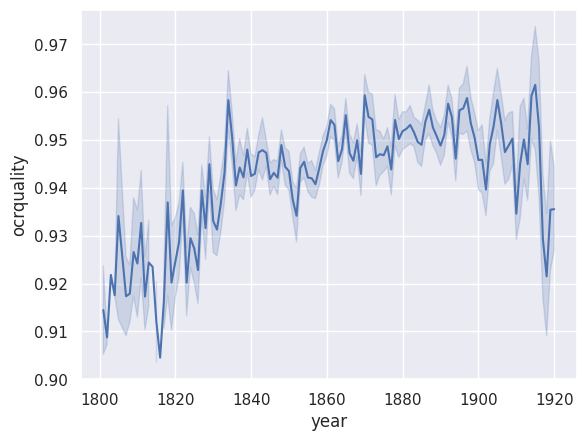

In [ ]:
# plot the OCR quality by year
sns.lineplot(x='year',y='ocrquality',data=df_large)

<Axes: xlabel='month', ylabel='ocrquality'>

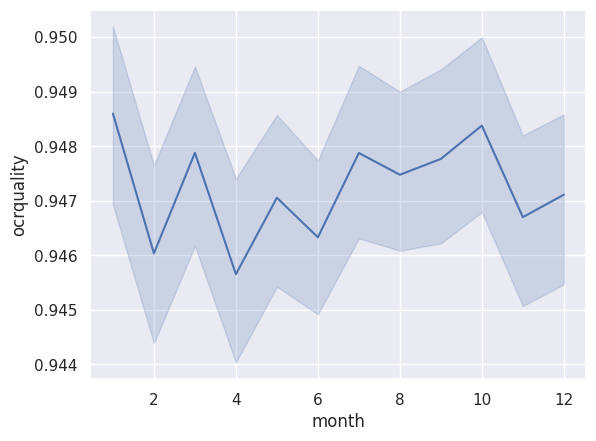

In [ ]:
# plot the OCR quality by month
sns.lineplot(x='month',y='ocrquality',data=df_large)

## Question

Is there a significant change in OCR quality over the nineteenth century but not by month?

In [ ]:
# compute the number of words for each document
df_large['num_words'] = df_large.text.apply(lambda x: len(x.split()))

<Axes: xlabel='year', ylabel='num_words'>

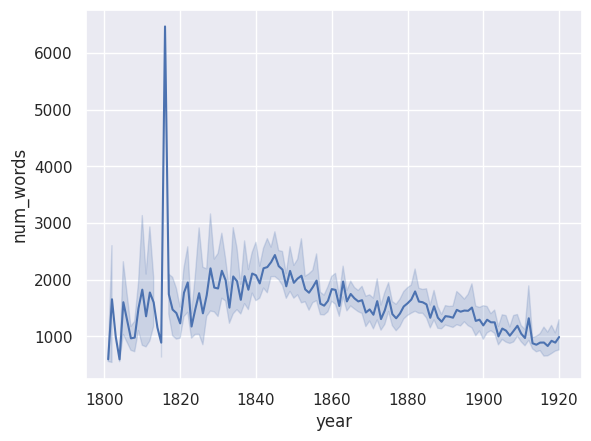

In [ ]:
# plot the average document length
sns.lineplot(x='year',y='num_words',data=df_large)

<Axes: xlabel='month', ylabel='num_words'>

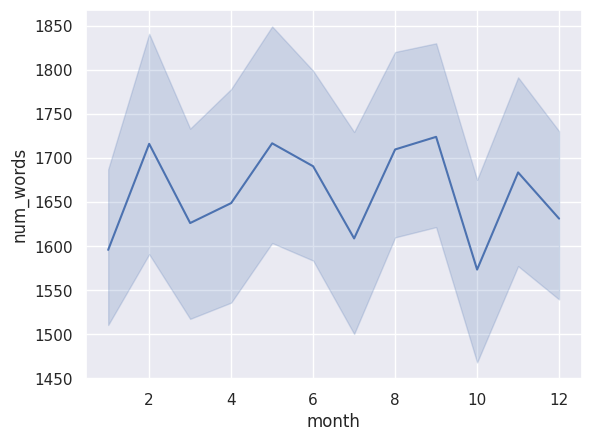

In [ ]:
# plot the average document length by month
sns.lineplot(x='month',y='num_words',data=df_large)

100%|██████████| 10000/10000 [00:05<00:00, 1951.38it/s]


<Axes: xlabel='month'>

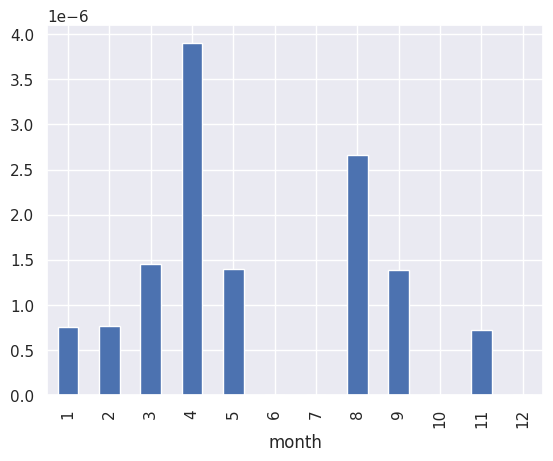

In [ ]:
# search the corpus using a particular regular expression
tqdm.pandas() # use tqdm to print a progress bar
#pattern = re.compile(r'\btoo cold\b', re.I)
#pattern = re.compile(r'\btoo hot\b', re.I)
pattern = re.compile(r'\bcricket\b', re.I) # create and compile a regex pattern
df_large['matches'] = df_large.text.progress_apply(lambda x: pattern.findall(x)) # apply compile regular expression
df_large['num_matches'] = df_large.matches.apply(len) # count number of hits for each document
df_large['matches_ratio'] = df_large['num_matches'] / df_large['num_words'] # compute the ratio of hits
sns.barplot(x='month',y='matches_ratio',data=df_large) # plot the results with error bars

# Fin.